In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import scipy.io
stims_train = scipy.io.loadmat('/kaggle/input/movie-64-dataset/train_stim.mat')
stims_test = scipy.io.loadmat('/kaggle/input/movie-64-dataset/test_stim.mat')
train_stim = stims_train['st_new']
test_stim = stims_test['sv_new']
print(train_stim.shape)
print(test_stim.shape)

(64, 64, 3, 108000)
(64, 64, 3, 8100)


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F

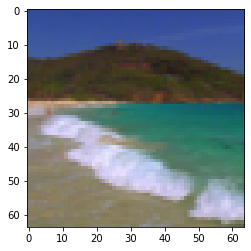

In [3]:
plt.imshow(train_stim[:,:,:,2400])

In [4]:
x_test = []

for i in range(50000):
  x_test.append(np.transpose(train_stim[:,:,:,i],(2, 0, 1)))

x = np.asarray(x_test)

print(x.shape)
del x_test
del train_stim

(50000, 3, 64, 64)


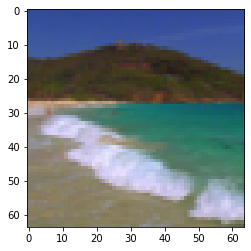

In [5]:
plt.imshow(np.transpose(x[2400,:], (1, 2, 0)))

In [6]:
# img_std  =  0.5 
# img_mean  =  0.5
x = x/np.max(x)
# x = (x - img_mean)/img_std
y = np.ones((50000,1))[:,0]
print(y.shape)

(50000,)


In [7]:
import torchvision

train = torch.utils.data.TensorDataset(torch.tensor(x), torch.tensor(y))
train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=False)

In [9]:
def imshow(img):
    img = img # / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0))) 

 
#Define the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

#Obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

1.0
0.0


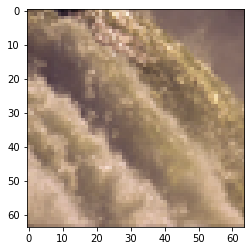

In [10]:
imshow(images[10])
print(np.max(x))
print(np.min(x))

In [115]:
#Define the Convolutional Autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
       
        #Encoder
        self.encoder = nn.Sequential(nn.Conv2d(3, 32, 3, padding=1),
                                     nn.ReLU(),
                                     nn.MaxPool2d(2, 2),
                                     nn.Conv2d(32, 64, 3, padding=1),
                                     nn.ReLU(),
                                     nn.MaxPool2d(2, 2),
                                     nn.Conv2d(64, 128, 3, padding=1),
                                     nn.ReLU(),
                                     nn.MaxPool2d(2,2)
        )
       
        #Decoder
        self.decoder = nn.Sequential(nn.ConvTranspose2d(128, 64, 2, stride=2),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(64, 32, 2, stride=2),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(32, 3, 2, stride=2),
                                     nn.Sigmoid()
        )


    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
              
        return x

In [73]:
class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x*psi

In [104]:
class conv_block(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(conv_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,padding=1),
            nn.BatchNorm2d(ch_out),
            nn.ReLU()
        )


    def forward(self,x):
        x = self.conv(x)
        return x

class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.ConvTranspose2d(ch_in,ch_out,kernel_size=2,stride=2),
            nn.BatchNorm2d(ch_out),
            nn.ReLU()
        )

    def forward(self,x):
        x = self.up(x)
        return x


class CAE_Attention(nn.Module):
    def __init__(self,img_ch=3,output_ch=1):
        super(CAE_Attention,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(2,2)
        
        self.sigmoid = nn.Sigmoid()

        self.Conv1 = conv_block(ch_in=img_ch,ch_out=32)
        self.Conv2 = conv_block(ch_in=32,ch_out=64)
        self.Conv3 = conv_block(ch_in=64,ch_out=128)
        
        self.Up3 = up_conv(ch_in=128,ch_out=64)
        self.Att3 = Attention_block(F_g=64,F_l=64,F_int=32)
        self.Up_conv3 = conv_block(ch_in=128, ch_out=64)
        
        self.Up2 = up_conv(ch_in=64,ch_out=32)
        self.Att2 = Attention_block(F_g=32,F_l=32,F_int=16)
        self.Up_conv2 = conv_block(ch_in=64, ch_out=32)
        
        self.Up1 = up_conv(ch_in=32,ch_out=3)


    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        
        # decoding + concat path
        

        d3 = self.Up3(self.Maxpool(x3))
        x2 = self.Att3(g=d3,x=self.Maxpool(x2))
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2,x=self.Maxpool(x1))
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Up1(d2)
        d1 = self.sigmoid(d1)

        return d1


In [116]:
#Instantiate the model
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(32, 3, kernel_size=(2, 2), stride=(2, 2))
    (5): Sigmoid()
  )
)


In [121]:
import math
import torch
import itertools as it
from torch.optim import Optimizer
from collections import defaultdict

class Lookahead(Optimizer):
    '''
    PyTorch implementation of the lookahead wrapper.
    Lookahead Optimizer: https://arxiv.org/abs/1907.08610
    '''
    def __init__(self, optimizer,alpha=0.5, k=6,pullback_momentum="none"):
        '''
        :param optimizer:inner optimizer
        :param k (int): number of lookahead steps
        :param alpha(float): linear interpolation factor. 1.0 recovers the inner optimizer.
        :param pullback_momentum (str): change to inner optimizer momentum on interpolation update
        '''
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        self.optimizer = optimizer
        self.param_groups = self.optimizer.param_groups
        self.alpha = alpha
        self.k = k
        self.step_counter = 0
        assert pullback_momentum in ["reset", "pullback", "none"]
        self.pullback_momentum = pullback_momentum
        self.state = defaultdict(dict)

        # Cache the current optimizer parameters
        for group in self.optimizer.param_groups:
            for p in group['params']:
                param_state = self.state[p]
                param_state['cached_params'] = torch.zeros_like(p.data)
                param_state['cached_params'].copy_(p.data)

    def __getstate__(self):
        return {
            'state': self.state,
            'optimizer': self.optimizer,
            'alpha': self.alpha,
            'step_counter': self.step_counter,
            'k':self.k,
            'pullback_momentum': self.pullback_momentum
        }

    def zero_grad(self):
        self.optimizer.zero_grad()

    def state_dict(self):
        return self.optimizer.state_dict()

    def load_state_dict(self, state_dict):
        self.optimizer.load_state_dict(state_dict)

    def _backup_and_load_cache(self):
        """Useful for performing evaluation on the slow weights (which typically generalize better)
        """
        for group in self.optimizer.param_groups:
            for p in group['params']:
                param_state = self.state[p]
                param_state['backup_params'] = torch.zeros_like(p.data)
                param_state['backup_params'].copy_(p.data)
                p.data.copy_(param_state['cached_params'])

    def _clear_and_load_backup(self):
        for group in self.optimizer.param_groups:
            for p in group['params']:
                param_state = self.state[p]
                p.data.copy_(param_state['backup_params'])
                del param_state['backup_params']

    def step(self, closure=None):
        """Performs a single Lookahead optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = self.optimizer.step(closure)
        self.step_counter += 1

        if self.step_counter >= self.k:
            self.step_counter = 0
            # Lookahead and cache the current optimizer parameters
            for group in self.optimizer.param_groups:
                for p in group['params']:
                    param_state = self.state[p]
                    p.data.mul_(self.alpha).add_(1.0 - self.alpha, param_state['cached_params'])  # crucial line
                    param_state['cached_params'].copy_(p.data)
                    if self.pullback_momentum == "pullback":
                        internal_momentum = self.optimizer.state[p]["momentum_buffer"]
                        self.optimizer.state[p]["momentum_buffer"] = internal_momentum.mul_(self.alpha).add_(
                            1.0 - self.alpha, param_state["cached_mom"])
                        param_state["cached_mom"] = self.optimizer.state[p]["momentum_buffer"]
                    elif self.pullback_momentum == "reset":
                        self.optimizer.state[p]["momentum_buffer"] = torch.zeros_like(p.data)

        return loss

In [122]:
#Loss function
criterion = nn.MSELoss()

#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

optimizer = Lookahead(optimizer)

def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)
model.to(device)

cuda:0


ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(32, 3, kernel_size=(2, 2), stride=(2, 2))
    (5): Sigmoid()
  )
)

In [119]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.type(torch.FloatTensor)
images = images.to(device)
outputs = model(images)
outputs.shape
# print(model.encoder(images[0:1].type(torch.FloatTensor).to(device)).flatten().shape)

torch.Size([32, 3, 64, 64])

In [ ]:
# del dataiter
# del images
# del labels

In [123]:
#Epochs
n_epochs = 50

epoch_loss = []

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0

    #Training
    for data in train_loader:
        images, _ = data
        images = images.type(torch.FloatTensor)
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
          
    train_loss = train_loss/len(train_loader)
    epoch_loss.append(train_loss)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

Epoch: 1 	Training Loss: 0.594400
Epoch: 2 	Training Loss: 0.245691
Epoch: 3 	Training Loss: 0.220030
Epoch: 4 	Training Loss: 0.202920
Epoch: 5 	Training Loss: 0.192575
Epoch: 6 	Training Loss: 0.178421
Epoch: 7 	Training Loss: 0.160194
Epoch: 8 	Training Loss: 0.147968
Epoch: 9 	Training Loss: 0.140455
Epoch: 10 	Training Loss: 0.135979
Epoch: 11 	Training Loss: 0.129716
Epoch: 12 	Training Loss: 0.127719
Epoch: 13 	Training Loss: 0.123446
Epoch: 14 	Training Loss: 0.121569
Epoch: 15 	Training Loss: 0.118366
Epoch: 16 	Training Loss: 0.116739
Epoch: 17 	Training Loss: 0.114167
Epoch: 18 	Training Loss: 0.112534
Epoch: 19 	Training Loss: 0.111021
Epoch: 20 	Training Loss: 0.108988
Epoch: 21 	Training Loss: 0.108131
Epoch: 22 	Training Loss: 0.106269
Epoch: 23 	Training Loss: 0.105507
Epoch: 24 	Training Loss: 0.104140
Epoch: 25 	Training Loss: 0.103651
Epoch: 26 	Training Loss: 0.102324
Epoch: 27 	Training Loss: 0.101237
Epoch: 28 	Training Loss: 0.100582
Epoch: 29 	Training Loss: 0.0

In [124]:
dataiter = iter(train_loader)
for i in range(1):
    images, labels = dataiter.next()

Original Images


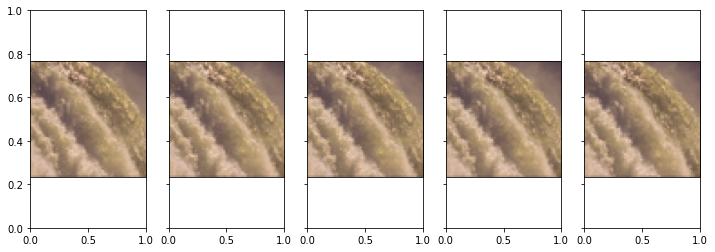

Reconstructed Images


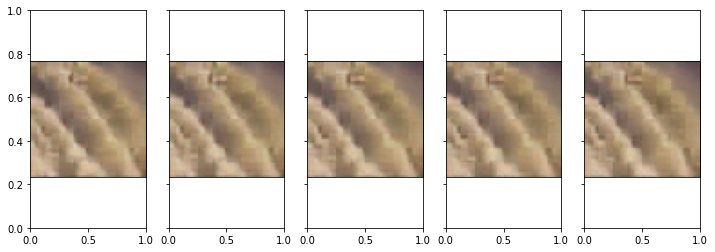

In [125]:
#Sample outputs
images = images.type(torch.FloatTensor)
output = model(images.to(device))
images = images.numpy()

output = output.view(32, 3, 64, 64)
output = output.cpu().detach().numpy()

#Original Images
print("Original Images")
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx+20])
   # ax.set_title(classes[labels[idx]])
plt.show()

#Reconstructed Images
print('Reconstructed Images')
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(output[idx+20])
   # ax.set_title(classes[labels[idx]])
plt.show()

In [ ]:
a_file = open("epoch_loss_lookahead_CAE.txt", "w")
for row in np.asarray(epoch_loss).reshape(len(np.asarray(epoch_loss)),1):
    np.savetxt(a_file, row)

a_file.close()

In [ ]:
x_test2 = []

for i in range(test_stim.shape[3]):
  x_test2.append(np.transpose(test_stim[:,:,:,i],(2, 0, 1)))

x2 = np.asarray(x_test2)

print(x2.shape)

# img_std  =  0.5 
# img_mean  =  0.5
x2 = x2/np.max(x2)
# x = (x - img_mean)/img_std
y2 = np.ones((8100,1))[:,0]
print(y2.shape)

In [ ]:
del test_stim
del x_test2

In [ ]:
del x
del y
del images
del labels

In [ ]:
del y2

In [ ]:
del output

In [ ]:
# test = torch.utils.data.TensorDataset(torch.tensor(x2), torch.tensor(y2))
# test_loader = torch.utils.data.DataLoader(test, batch_size=8100, shuffle=False)

In [ ]:
# dataiter = iter(test_loader)
# images, labels = dataiter.next()
output2 = model(torch.tensor(x2).type(torch.FloatTensor).to(device))
output2 = output2.view(8100, 3, 64, 64)
output2 = output2.cpu().detach().numpy()

In [ ]:
print("Original Images")
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
   # ax.set_title(classes[labels[idx]])
plt.show()

print('Reconstructed Images')
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(output2[idx])
   # ax.set_title(classes[labels[idx]])
plt.show()

In [ ]:
del output2

In [ ]:
mean_enc_output = []
for i in range(0,images.shape[0]):
    normalized_flatten = model.encoder(images[i:i+1].to(device))[0,:].flatten()
    normalized_flatten = normalized_flatten/torch.max(normalized_flatten)
    mean_enc_output.append(torch.mean(normalized_flatten).cpu().detach().numpy())
    
plt.plot(np.linspace(0,540,8100),mean_enc_output,'r')

a_file = open("mean_enc_op_64.txt", "w")
for row in np.asarray(mean_enc_output).reshape(len(np.asarray(mean_enc_output)),1):
    np.savetxt(a_file, row)

a_file.close()